## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [4]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.label_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Auto-encoder Architecture

In [43]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- 1D Convolution (Time Aggregation) ---
        self.conv1d = nn.Conv1d(6400, 6400, kernel_size=time_steps, stride=1, padding=0, groups=800)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6400, 512)  # Time is now 1, so we multiply by 1
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 6400)  # Matches shape before Conv1D

        # --- 1D Deconvolution to Expand Time Back ---
        self.deconv1d = nn.ConvTranspose1d(6400, 6400, kernel_size=time_steps, stride=1, padding=0, groups=6400)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Reshape for 1D Conv ---
        b, c, t, h, w = x.shape  
        # print("x shape initial: ",x.shape)
        x = x.view(b, c * h * w, t)  # Shape: (batch, 800, time)

        # print(f"Shape before 1D Conv: {x.shape}")  # Debugging
        x = self.conv1d(x)  # Time aggregation
        # print(f"Shape after 1D Conv: {x.shape}")  # Expected: (batch, 800, 1)

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x) 

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x)) 

        # --- Expand Time Back ---
        x = x.view(b, 6400, 1)  # Shape before Transpose 1D
        x = self.deconv1d(x)  # Expands time dimension back
        # print(f"Shape after Deconv1D: {x.shape}")  # Expected: (batch, 800, time_steps)

        # --- Reshape for 3D Deconvolutions ---
        x = x.view(b, -1, self.time_steps, h, w)  # Matches pre-Conv1D shape
        # print("x before unflatten", x.shape)

        # --- 3D Deconvolutions ---
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)  # Final output

        return z, x_reconstructed


In [39]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class Conv3DAutoencoder(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size, patch_size):
#         super(Conv3DAutoencoder, self).__init__()

#         self.time_steps = time_steps
#         self.in_channels = in_channels

#         # --- Encoder (3D Convolutions) ---
#         self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)

#         # --- Flatten and Fully Connected Latent Space ---
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64 * patch_size * patch_size * time_steps, 128)  # Reduced layer size
#         self.fc2 = nn.Linear(128, latent_size)

#         # --- Decoder ---
#         self.fc3 = nn.Linear(latent_size, 128)
#         self.fc4 = nn.Linear(128, 64 * patch_size * patch_size * time_steps)

#         # --- 3D Deconvolutions (Upsampling) ---
#         self.deconv1 = nn.ConvTranspose3d(64, 32, kernel_size=3, stride=1, padding=1)
#         self.deconv2 = nn.ConvTranspose3d(32, 16, kernel_size=3, stride=1, padding=1)
#         self.deconv3 = nn.ConvTranspose3d(16, in_channels, kernel_size=3, stride=1, padding=1)

#     def forward(self, x):
#         # --- Encoder ---
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))

#         # --- Flatten and Fully Connected ---
#         b, c, t, h, w = x.shape
#         x = x.view(b, -1)  # Flattening the output from 3D Conv layers
#         x = F.relu(self.fc1(x))
#         z = self.fc2(x)  # Latent representation

#         # --- Decoder ---
#         x = F.relu(self.fc3(z))
#         x = F.relu(self.fc4(x))

#         # --- Reshape for 3D Deconvolutions ---
#         x = x.view(b, 64, h, w, t)  # Reshape to match the output size for deconvolutions

#         # --- 3D Deconvolutions (Upsampling) ---
#         x = F.relu(self.deconv1(x))
#         x = F.relu(self.deconv2(x))
#         x_reconstructed = self.deconv3(x)  # Final output

#         return z, x_reconstructed


## Experiment 1: Data Cubes = B10 (Sentinel-2 Bands)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [6]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'allbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'allbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

### Create Sub-Patches

In [7]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 10, 5, 5]), torch.Size([867, 7, 10, 5, 5]))

Get field numbers and co-ordinates as string

In [8]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [9]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


### Training the Auto-encoder

Input Data: ( N x C x D x H x W )

In [57]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=16
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=800)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=6400)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deco

In [58]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/50, Train Loss: 0.0028, Test Loss: 0.0009
Epoch 2/50, Train Loss: 0.0007, Test Loss: 0.0058
Epoch 3/50, Train Loss: 0.0005, Test Loss: 0.0010
Epoch 4/50, Train Loss: 0.0004, Test Loss: 0.0021
Epoch 5/50, Train Loss: 0.0003, Test Loss: 0.0004
Epoch 6/50, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 7/50, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 8/50, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 9/50, Train Loss: 0.0002, Test Loss: 0.0009
Epoch 10/50, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 11/50, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 12/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 13/50, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 14/50, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 15/50, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 16/50, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 17/50, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 18/50, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 19/50, Train Loss: 0.0001, Test Loss: 0.0002
Epoch 20/50, Train Loss: 0.0001, Test Lo

In [46]:
# plot_loss(train_losses,test_losses)

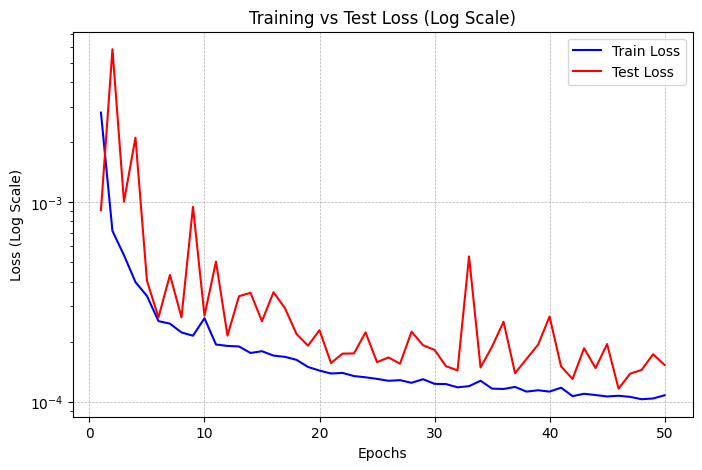

In [59]:
plot_loss_log_scale(train_losses, test_losses)

### Evaluation

Use trained Encoder part to get the features for train, test and evaluation Data

In [60]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [61]:
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

In [62]:
combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [63]:
kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=21)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [64]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [65]:
accuracy, report, cm, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.4426229508196721
              precision    recall  f1-score   support

           0       0.39      0.54      0.45        26
           1       0.52      0.37      0.43        35

    accuracy                           0.44        61
   macro avg       0.45      0.45      0.44        61
weighted avg       0.46      0.44      0.44        61



In [66]:
acc, precision_per_class, recall_per_class, f1_per_class = evaluate_clustering_metrics(eval_field_labels, config.labels_path)
print("Accuracy:",acc)
print("Precision:",precision_per_class)
print("Recall:",recall_per_class)
print("F1-score:",f1_per_class)

Accuracy: 0.5573770491803278
Precision: [0.48       0.61111111]
Recall: [0.46153846 0.62857143]
F1-score: [0.47058824 0.61971831]


## Experiment 2: Data Cubes = BVI (Bands with Vegetation Indices)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'multipleindicesbands')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'multipleindicesbands')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 7, 64, 64]), torch.Size([48, 7, 7, 64, 64]))

### Create Sub-Patches

In [6]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 7, 5, 5]), torch.Size([867, 7, 7, 5, 5]))

Get field numbers and co-ordinates as string

In [7]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [8]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


### Training the Auto-encoder

Input Data: ( N x C x D x H x W )

In [11]:
device = 'cuda'
epochs = 25
lr = 0.001
latent_dim=16
channels = 7
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(7, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=800)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=6400)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (decon

In [12]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/25, Train Loss: 0.0072, Test Loss: 0.0076
Epoch 2/25, Train Loss: 0.0024, Test Loss: 0.0023
Epoch 3/25, Train Loss: 0.0019, Test Loss: 0.0021
Epoch 4/25, Train Loss: 0.0015, Test Loss: 0.0015
Epoch 5/25, Train Loss: 0.0013, Test Loss: 0.0037
Epoch 6/25, Train Loss: 0.0012, Test Loss: 0.0015
Epoch 7/25, Train Loss: 0.0010, Test Loss: 0.0014
Epoch 8/25, Train Loss: 0.0009, Test Loss: 0.0016
Epoch 9/25, Train Loss: 0.0009, Test Loss: 0.0025
Epoch 10/25, Train Loss: 0.0009, Test Loss: 0.0014
Epoch 11/25, Train Loss: 0.0008, Test Loss: 0.0016
Epoch 12/25, Train Loss: 0.0009, Test Loss: 0.0026
Epoch 13/25, Train Loss: 0.0008, Test Loss: 0.0016
Epoch 14/25, Train Loss: 0.0008, Test Loss: 0.0011
Epoch 15/25, Train Loss: 0.0008, Test Loss: 0.0011
Epoch 16/25, Train Loss: 0.0008, Test Loss: 0.0023
Epoch 17/25, Train Loss: 0.0008, Test Loss: 0.0012
Epoch 18/25, Train Loss: 0.0007, Test Loss: 0.0056
Epoch 19/25, Train Loss: 0.0012, Test Loss: 0.0017
Epoch 20/25, Train Loss: 0.0008, Test Lo

In [13]:
# plot_loss(train_losses,test_losses)

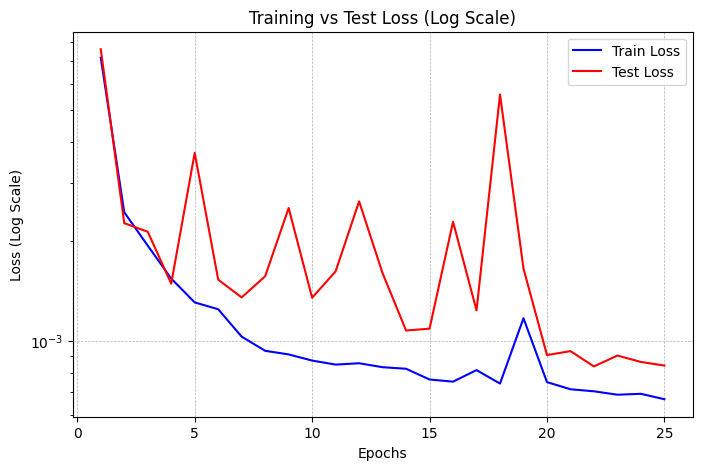

In [14]:
plot_loss_log_scale(train_losses, test_losses)

### Evaluation

Use trained Encoder part to get the features for train, test and evaluation Data

In [15]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [16]:
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

In [17]:
combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [19]:
kmeans_bvi = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=5)

train_subpatch_predictions = kmeans_bvi.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans_bvi.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [20]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [21]:
accuracy, report, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.5737704918032787
              precision    recall  f1-score   support

           0       0.50      0.31      0.38        26
           1       0.60      0.77      0.68        35

    accuracy                           0.57        61
   macro avg       0.55      0.54      0.53        61
weighted avg       0.56      0.57      0.55        61



## Experiment 3: Data Cubes = MVI (Multiple with Vegetation Indices)

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [5]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'multipleindices')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'multipleindices')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 3, 64, 64]), torch.Size([48, 7, 3, 64, 64]))

### Create Sub-Patches

In [6]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([39042, 7, 3, 5, 5]), torch.Size([867, 7, 3, 5, 5]))

Get field numbers and co-ordinates as string

In [7]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_25_25'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [8]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


### Training the Auto-encoder

Input Data: ( N x C x D x H x W )

In [22]:
device = 'cuda'
epochs = 25
lr = 0.001
latent_dim=32
channels = 3
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv1d): Conv1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=800)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=6400, bias=True)
  (deconv1d): ConvTranspose1d(6400, 6400, kernel_size=(7,), stride=(1,), groups=6400)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 5, 5))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (decon

In [23]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

Epoch 1/25, Train Loss: 0.0232, Test Loss: 0.0104
Epoch 2/25, Train Loss: 0.0056, Test Loss: 0.0041
Epoch 3/25, Train Loss: 0.0033, Test Loss: 0.0032
Epoch 4/25, Train Loss: 0.0029, Test Loss: 0.0032
Epoch 5/25, Train Loss: 0.0026, Test Loss: 0.0030
Epoch 6/25, Train Loss: 0.0021, Test Loss: 0.0032
Epoch 7/25, Train Loss: 0.0018, Test Loss: 0.0049
Epoch 8/25, Train Loss: 0.0017, Test Loss: 0.0021
Epoch 9/25, Train Loss: 0.0015, Test Loss: 0.0017
Epoch 10/25, Train Loss: 0.0014, Test Loss: 0.0026
Epoch 11/25, Train Loss: 0.0013, Test Loss: 0.0037
Epoch 12/25, Train Loss: 0.0013, Test Loss: 0.0019
Epoch 13/25, Train Loss: 0.0012, Test Loss: 0.0012
Epoch 14/25, Train Loss: 0.0012, Test Loss: 0.0046
Epoch 15/25, Train Loss: 0.0012, Test Loss: 0.0013
Epoch 16/25, Train Loss: 0.0011, Test Loss: 0.0016
Epoch 17/25, Train Loss: 0.0011, Test Loss: 0.0012
Epoch 18/25, Train Loss: 0.0010, Test Loss: 0.0014
Epoch 19/25, Train Loss: 0.0010, Test Loss: 0.0012
Epoch 20/25, Train Loss: 0.0010, Test Lo

In [24]:
# plot_loss(train_losses,test_losses)

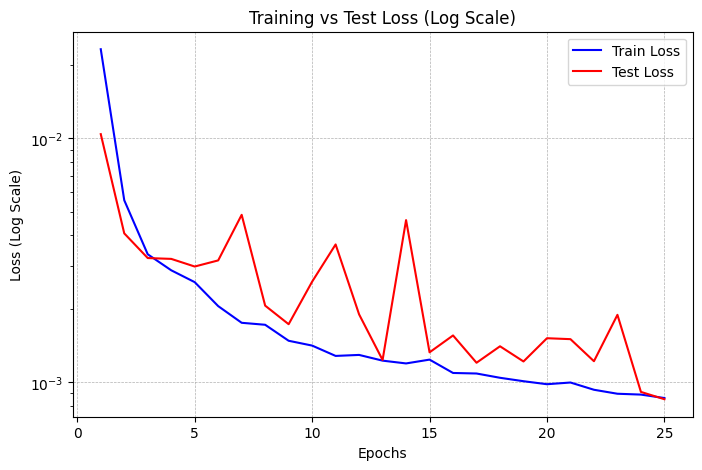

In [25]:
plot_loss_log_scale(train_losses, test_losses)

### Evaluation

Use trained Encoder part to get the features for train, test and evaluation Data

In [26]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [27]:
train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

In [28]:
combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [32]:
kmeans_mvi = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=8)

train_subpatch_predictions = kmeans_mvi.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans_mvi.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

/home/k64835/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Convert Subpatch labels to Field labels

In [33]:
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(combined_train_coords, train_subpatch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_subpatch_predictions, threshold)

Accuracy and Classification Report

In [38]:
accuracy, report, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Evaluation Accuracy: {accuracy}")
print(report)

Evaluation Accuracy: 0.6229508196721312
              precision    recall  f1-score   support

           0       0.64      0.80      0.71        35
           1       0.59      0.38      0.47        26

    accuracy                           0.62        61
   macro avg       0.61      0.59      0.59        61
weighted avg       0.62      0.62      0.60        61



## Final Images: Visualising Diseased Subpatches

In [47]:
eval_images_box = border_removed_images

In [48]:
(eval_images_box[0][0].shape)

(64, 64, 13)

In [49]:
np.unique(eval_images_box[0][0][:,:,-2])

array([      0., 1168039.])

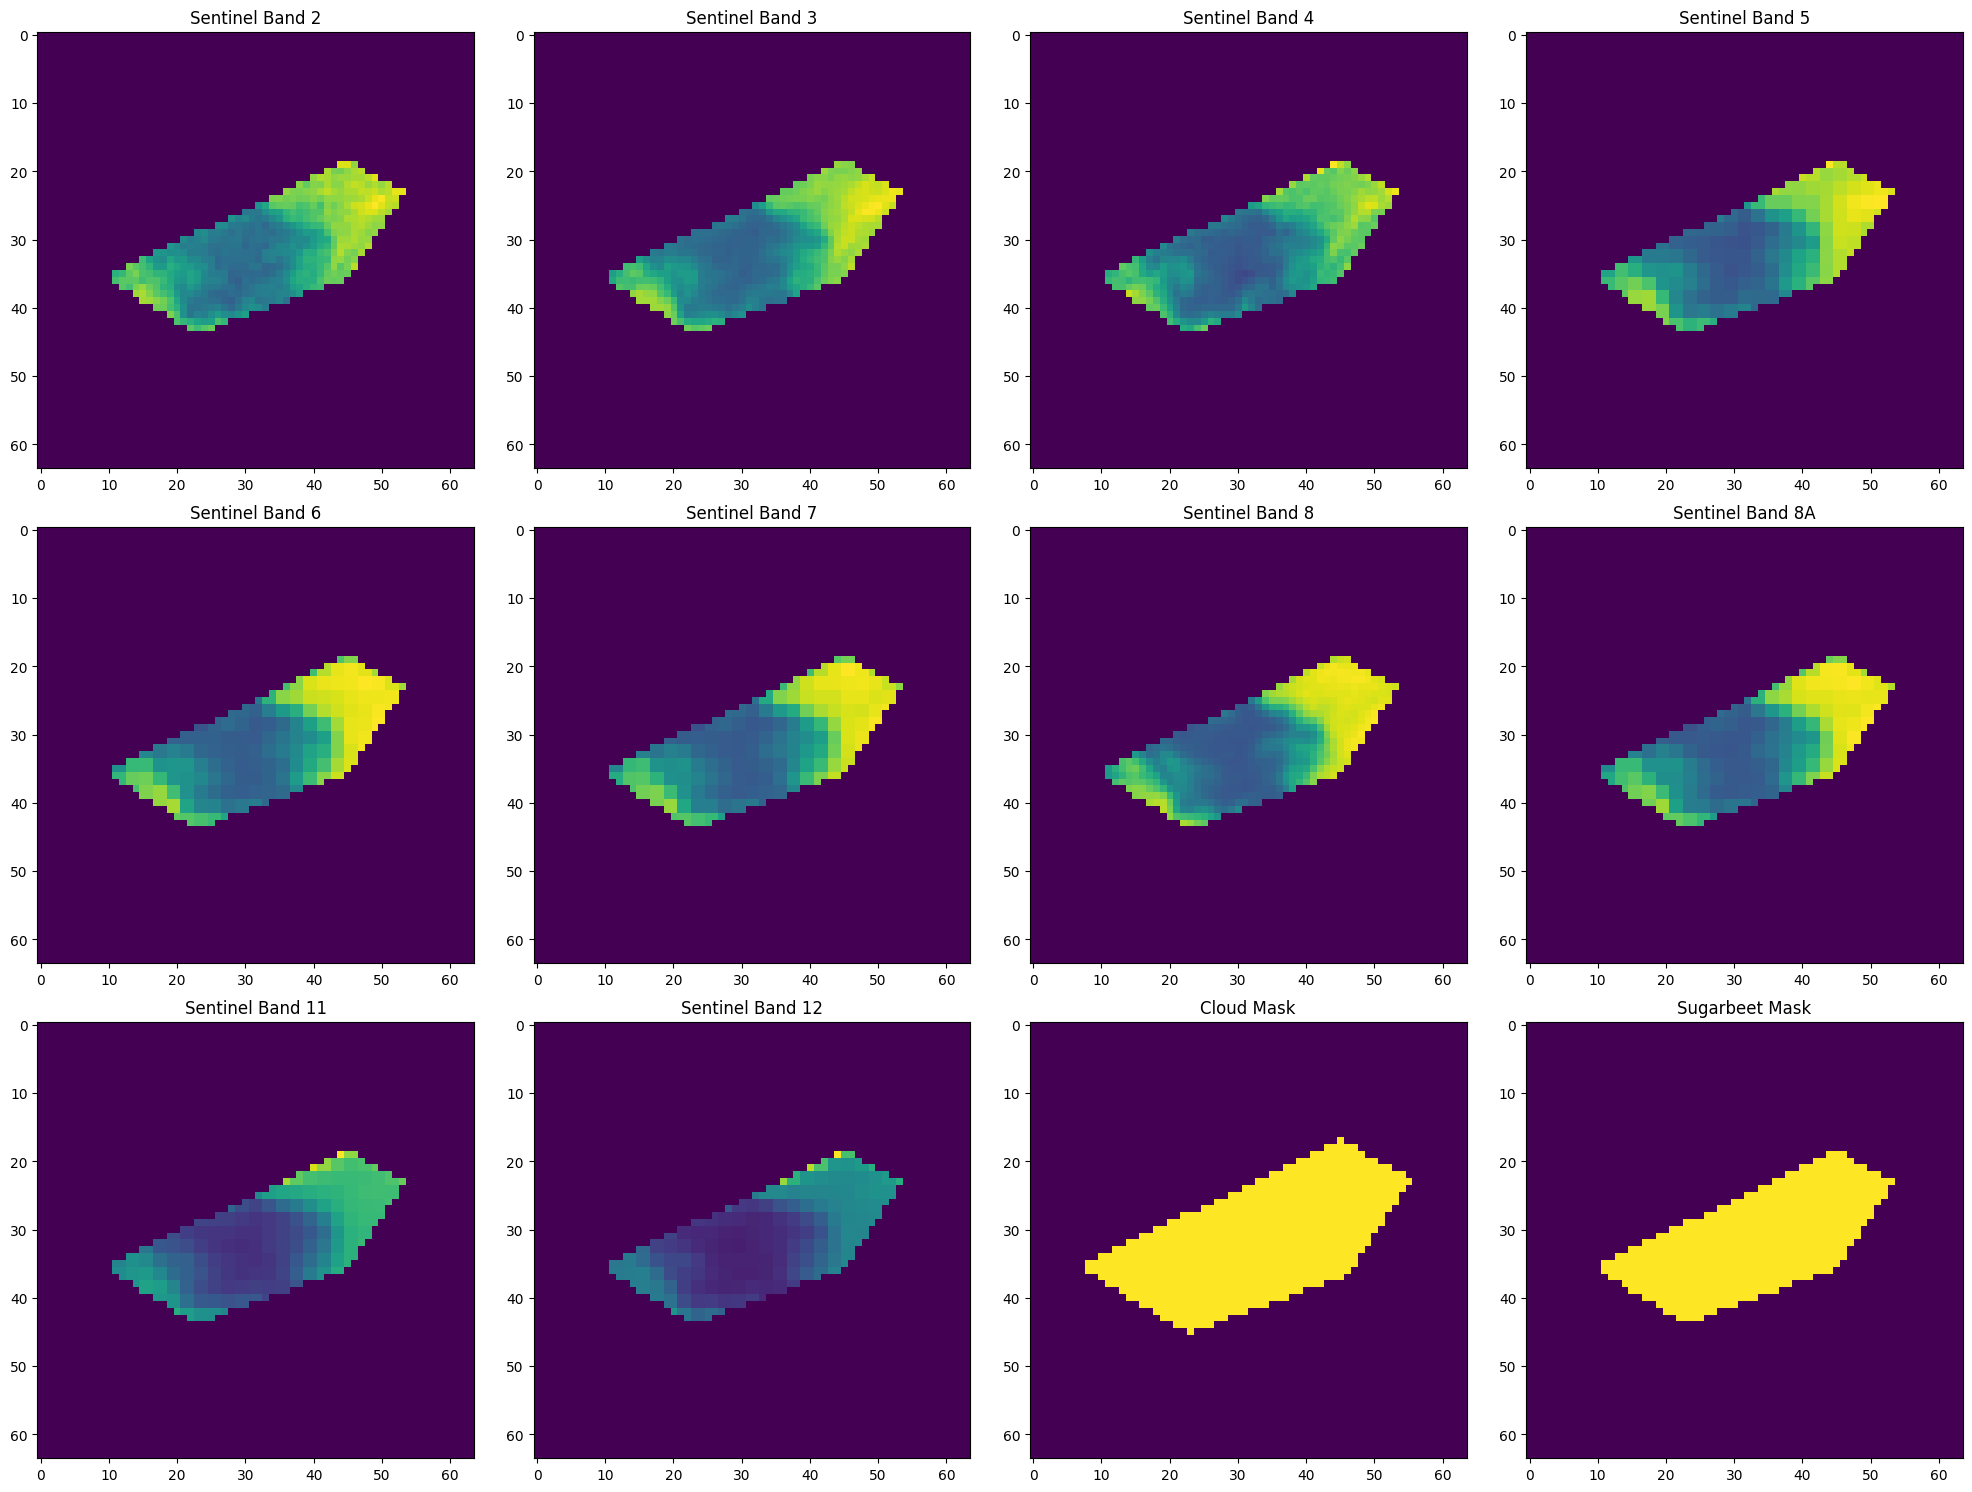

In [50]:
visualise_all_bands(eval_images_box[-15][3])

-48 -26

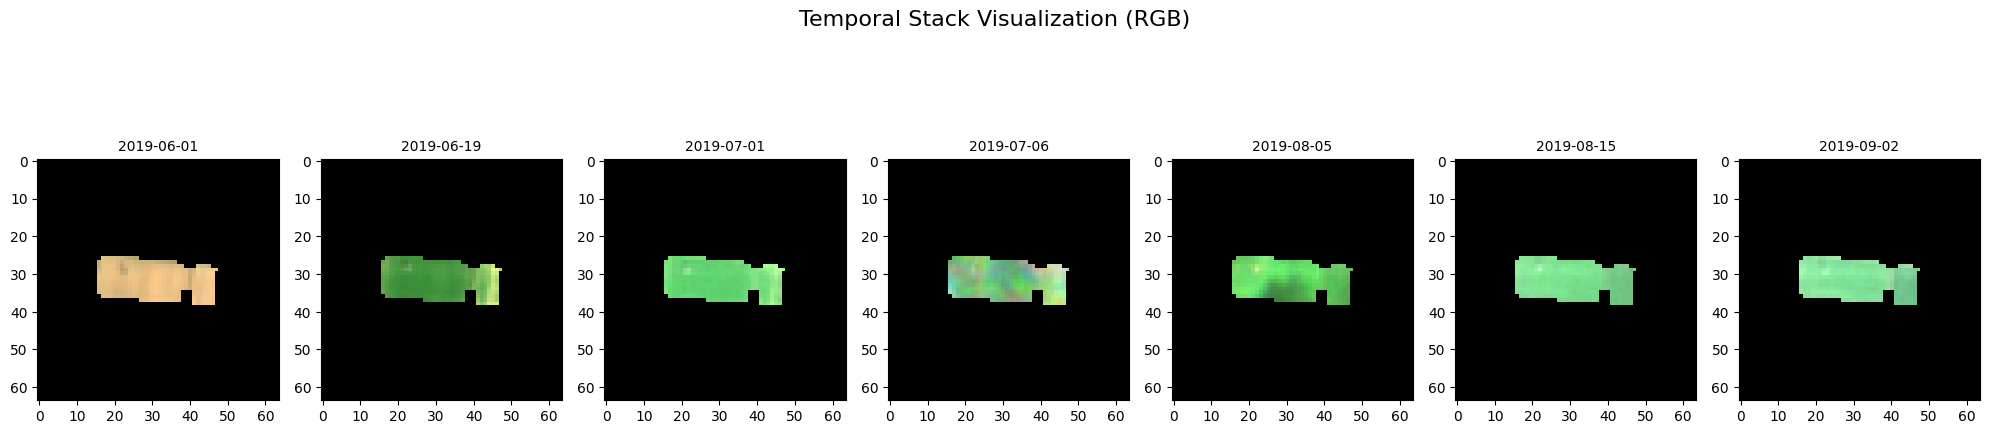

In [51]:
visualize_temporal_stack_rgb(eval_images_box[-26])

In [52]:
np.unique(eval_images_box[-26][-1][:,:,-2])

array([      0., 1196489., 1196747.])

Saved: /home/k64835/SITS-images/output/img_1168039.png
Saved: /home/k64835/SITS-images/output/img_1228889.png
Saved: /home/k64835/SITS-images/output/img_1168663.png
Saved: /home/k64835/SITS-images/output/img_1168692.png
Saved: /home/k64835/SITS-images/output/img_1171179.png
Saved: /home/k64835/SITS-images/output/img_1172001.png


/home/k64835/Master-Thesis-SITS/Modeling/model_scripts/superpixel.py:257: RuntimeWarning: invalid value encountered in divide
  


Saved: /home/k64835/SITS-images/output/img_1174805.png
Saved: /home/k64835/SITS-images/output/img_1176318.png
Saved: /home/k64835/SITS-images/output/img_1176365.png
Saved: /home/k64835/SITS-images/output/img_1177274.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1177490.png
Saved: /home/k64835/SITS-images/output/img_1178038.png
Saved: /home/k64835/SITS-images/output/img_1178198.png
Saved: /home/k64835/SITS-images/output/img_1179855.png
Saved: /home/k64835/SITS-images/output/img_1182776.png
Saved: /home/k64835/SITS-images/output/img_1182822.png
Saved: /home/k64835/SITS-images/output/img_1183171.png
Saved: /home/k64835/SITS-images/output/img_1194806.png
Saved: /home/k64835/SITS-images/output/img_1196327.png
Saved: /home/k64835/SITS-images/output/img_1196347.png
Saved: /home/k64835/SITS-images/output/img_1196489.png
Saved: /home/k64835/SITS-images/output/img_1216230.png
Saved: /home/k64835/SITS-images/output/img_1216239.png
Saved: /ho

/home/k64835/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


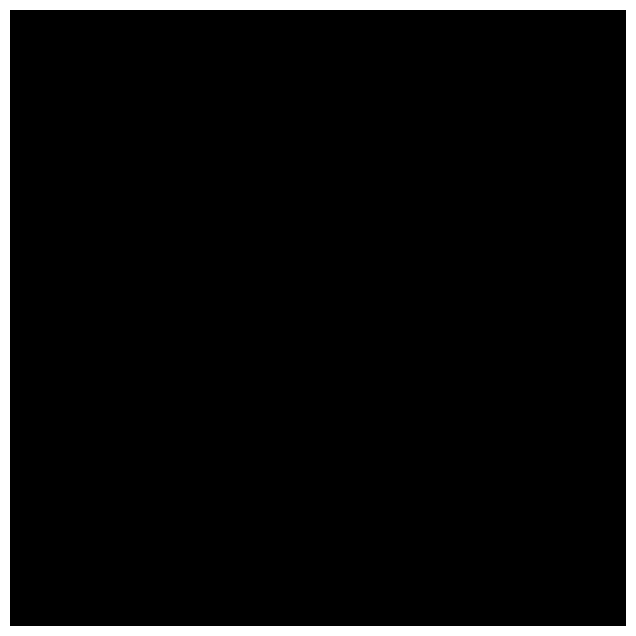

In [56]:
draw_diseased_patches(eval_images_box, x_y_coords, config.images_save_path, config.patch_size)

## Temp Cells 

In [23]:
def normalize_images(temporal_images):
    """
    Normalize the Sentinel-2 temporal images such that every channel in each temporal image is scaled to [0, 1],
    but only if it's needed (i.e., if the values are not already in the [0, 1] range).
    """
    normalized_images = []
    for field_images in temporal_images:
        field_normalized_images = []
        
        for temporal_image in field_images:
            normalized_temporal_image = np.zeros_like(temporal_image, dtype=np.float32)
            num_channels = temporal_image.shape[2]
            
            for c in range(num_channels): 

                # Skip normalization for the last 3 channels (masks etc.)
                if c >= num_channels - 3:
                    normalized_temporal_image[:, :, c] = temporal_image[:, :, c]

                band = temporal_image[:, :, c]
                band_min = np.min(band)
                band_max = np.max(band)
                
                if band_min >= 0 and band_max <= 1:
                    # If the band is already in the [0, 1] range, don't normalize
                    normalized_band = band
                else:
                    # Normalize the band to [0, 1] range
                    if band_max > band_min:
                        normalized_band = (band - band_min) / (band_max - band_min)
                    else:
                        normalized_band = np.zeros_like(band)  # If no variance, just set to zeros
                
                normalized_temporal_image[:, :, c] = normalized_band
            field_normalized_images.append(normalized_temporal_image)
        normalized_images.append(field_normalized_images)
    return normalized_images

In [11]:
temporal_images = load_field_images_temporal(config.load_directory_temporal_eval)

In [13]:
border_removed_images = blacken_field_borders_temporal(temporal_images)

In [14]:
border_removed_images[0][0].shape

(64, 64, 13)

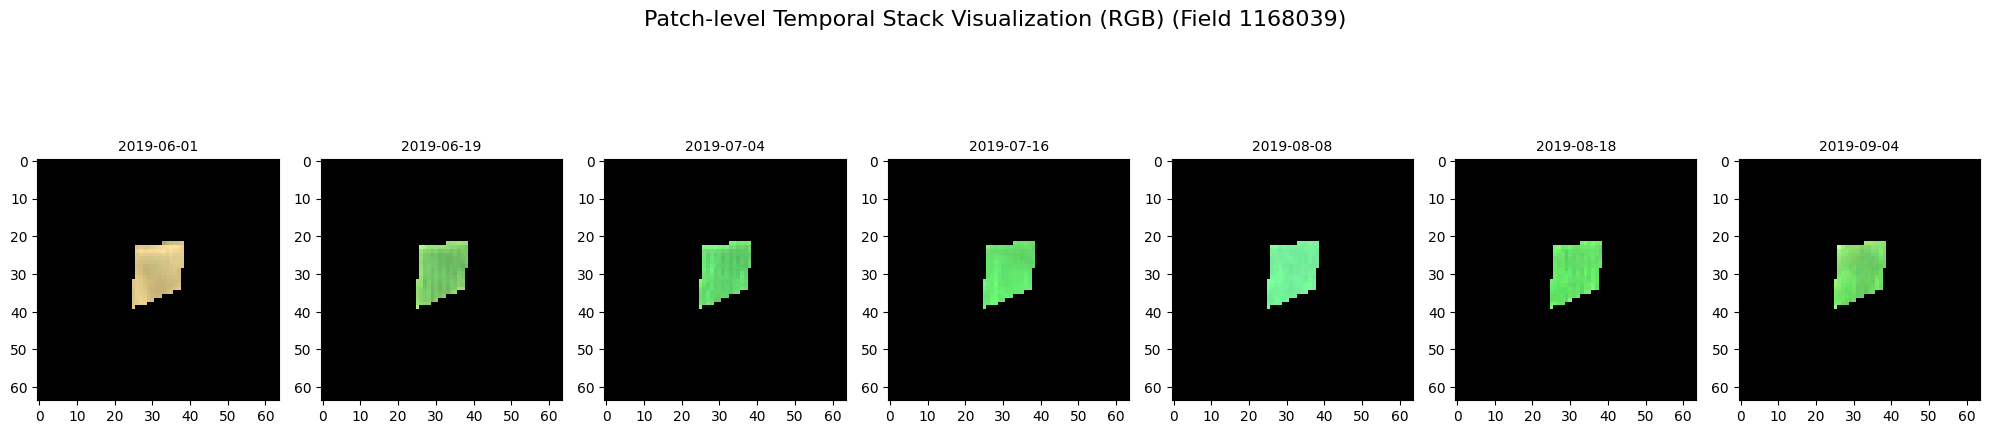

In [25]:
visualize_temporal_stack_rgb(border_removed_images[0],acquisition_dates_eval[field_numbers_eval[0]])

In [24]:
norm_images = normalize_images(border_removed_images)

In [26]:
np.unique(border_removed_images[0][0][:,:,-2])

array([      0., 1168039.])

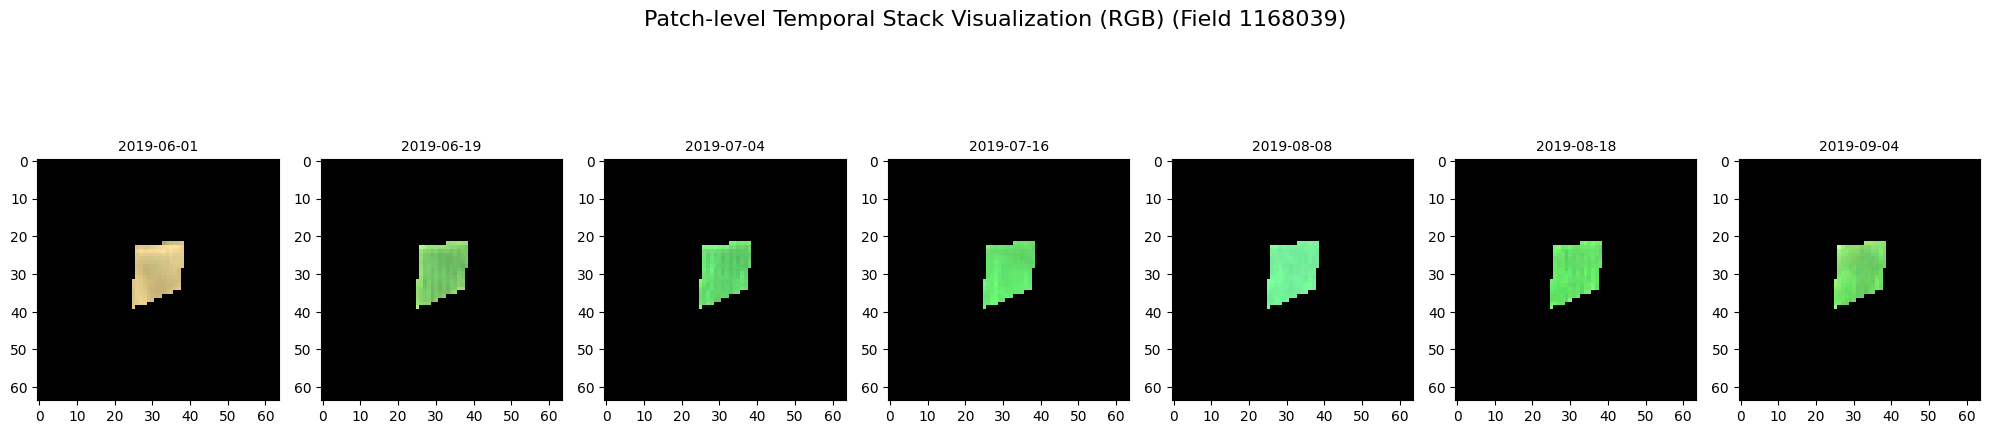

In [33]:
visualize_temporal_stack_rgb(norm_images[0],acquisition_dates_eval[field_numbers_eval[0]])